Contents
========

This notebook carries out all the calculations and produces all the plots from Krumholz (2018), "Resolution Requirements and Resolution Problems in Simulations of Radiative Feedback in Dusty Gas".

Before you can run it, you must first compile the c code ``shell_sim.c``, included with this package. The code is vanilla c99, and should be straightforward to compile on mac or unix just by typing ``make`` in the directory where the code is located.

The notebook is broken into a few sections, corresponding to the sections in the paper.

General setup
-------------

First we import all the tools we're doing to need, and define some constants that will be used throughout the rest of the calculation.

In [1]:
# Make plots appear inline
%matplotlib inline

In [2]:
# Import libraries
import numpy as np
import matplotlib.pyplot as plt

In [3]:
# Import the code that initializes the infall solution and runs simulations
from infall_sol import infall_init, u_inf, m_inf, fpcrit_inf, \
    dp_grav_inf, dp_IR_inf, dp_UV_inf
from shell_sim import run_sim, f_grav, f_UV, f_IR, f_visc, f_pres

In [4]:
# Physical constants and units
G         = 6.67408e-8  # Newton's constant
c         = 2.99792e10  # Speed of light
sigma_SB  = 5.67037e-5  # Stefan-Boltzmann constant
Msun      = 1.98855e33  # Solar mass
Lsun      = 3.82800e33  # Solar luminosity
AU        = 1.49598e13  # Astronomical unit
pc        = 6.48e5/np.pi  # Parsec
yr        = 365.25*24.*3600. # yr

# Choose parameters that we will hold fixed
Ts        = 1500.    # Dust sublimation temperature = 1500 K
T0        = 150.     # Temperature at which IR opacity begins to drop = 150 K
Q         = 0.01     # Grain absorption efficiency at sublimation temperature
kappa_IR0 = 7.0      # Peak IR opacity = 7 cm^2 g^-1
kappa_s   = 7.0e2    # Opacity to starlight = 700 cm^2 g^-1
kT        = 0.5      # Logarithmic slope of temperature in IR-dominated region
phi       = 0.4      # Temperature / sublimation temperature just inside sublimation zone
Psi       = 1.1e3*Lsun/Msun    # Light to mass ratio

# Parameters derived from the above
eta       = kappa_s / kappa_IR0
fE        = kappa_IR0 * Psi / (4.0*np.pi*G*c)
ftau      = 16*np.pi*Q*sigma_SB*Ts**4*eta*kappa_IR0 / Psi
xT        = (phi*Ts/T0)**(1/kT)
fpcrit    = fpcrit_inf(fE, kT, xT)

# Dimensional scalings
Ls        = 1.0e6*Lsun
Ms        = Ls/Psi
rs        = np.sqrt(Ls/(16*np.pi*Q*sigma_SB*Ts**4))
vs        = np.sqrt(G*Ms/rs)
ts        = np.sqrt(rs**3/(G*Ms))
rhos      = Ms/rs**3

High resolution test
-------------------

This section carries out the high resolution tests described in section 3.2.1 of the paper. It produces figure 2 of the paper.

In [5]:
# Set resolution
dm        = 1.0e-6
npt       = 500        # Number of mass points
x0        = 1.000001   # Radius of first point

# Set the list of f_p values at which to run
fp        = [0.4, 0.8, 1.2, 1.6, 2.0]

In [6]:
# Print dimensional scalings
print("Ms = {:f} Msun".format(Ms/Msun))
print("dm = {:e} Msun".format(dm*Ms/Msun))
print("rs = {:f} AU".format(rs/AU))
print("ts = {:f} yr".format(ts/yr))
print("vs = {:f} km s^-1".format(vs/1e5))
print("rhos = {:e} mH cm^-3".format(rhos/2.34e-24))
print("Mdot = ")
for fp_ in fp:
    print("   {:e} Msun yr^-1".
          format(fp_*Ls/c/np.sqrt(G*Ms/rs)/(Msun/yr)))

Ms = 909.090909 Msun
dm = 9.090909e-04 Msun
rs = 344.300008 AU
ts = 33.722724 yr
vs = 48.398980 km s^-1
rhos = 5.653788e+12 mH cm^-3
Mdot = 
   1.674724e-04 Msun yr^-1
   3.349447e-04 Msun yr^-1
   5.024171e-04 Msun yr^-1
   6.698894e-04 Msun yr^-1
   8.373618e-04 Msun yr^-1


In [7]:
# Run various f_p values
xu_hist = []
nhist = 1000
for fp_ in fp:
    
    # Build initial condition
    xu = infall_init(dm, npt, x0, fE, fp_, ftau, eta, kT, xT)
    
    # Run simulation
    xu_hist_tmp, tf = run_sim(xu, 1.0, dm, fE, ftau, eta, kT, xT,
                              nu=2.0, cs2=1.0e-3, xsink=0.5, 
                              cfl=0.5, verbose=True)
    xu_hist.append(xu_hist_tmp)
    
    # Print status
    print("Completed case fp = {:3.1f}, tf = {:3.1f}".
          format(fp_, tf))

Completed case fp = 0.4, tf = 1.0
Completed case fp = 0.8, tf = 1.0
Completed case fp = 1.2, tf = 1.0
Completed case fp = 1.6, tf = 1.0
Completed case fp = 2.0, tf = 1.0


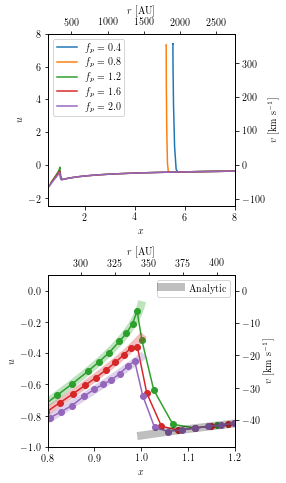

In [8]:
# Plot the velocity structure in the various cases; use one
# panel zoomed in on the shock to show the structure there, and
# a second zoomed out to show the shell cases
fig = plt.figure(1, figsize=(4,7))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Panel showing larger region
plt.subplot(2,1,1)
for i, fp_ in enumerate(fp):
    nsink = np.sum(xu_hist[i][-1,:npt] == 0.5)+1
    plt.plot(xu_hist[i][-1,nsink:npt], xu_hist[i][-1,npt+nsink:], 
             color='C'+str(i),
             label=r'$f_p={:3.1f}$'.format(fp_))
plt.legend(loc='upper left')
plt.xlim([0.5,8])
plt.ylim([-2.5,8])
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')

# Add top and right labels
plt.twinx()
plt.ylim(np.array([-2.5,8])*vs/1e5)
plt.ylabel(r'$v$ [km s$^{-1}$]')
plt.twiny()
plt.xlim(np.array([0.5,8])*rs/AU)
plt.xlabel(r'$r$ [AU]')

# Panel showing a zoomed-in region
plt.subplot(2,1,2)
for i, fp_ in enumerate(fp):
    nsink = np.sum(xu_hist[i][-1,:npt] == 0.5)
    plt.plot(xu_hist[i][-1,nsink:npt], xu_hist[i][-1,npt+nsink:], 
             color='C'+str(i))
    plt.plot(xu_hist[i][-1,nsink:npt], xu_hist[i][-1,npt+nsink:], 'o', 
             color='C'+str(i))
    if fp_ > fpcrit:
        if i == len(fp)-1:
            x_analyt = np.linspace(1, 1.5, 1000)
            plt.plot(x_analyt, u_inf(x_analyt, fE, fp_, kT, xT), 
                     color='k',
                     lw=8, alpha=0.25,
                     label='Analytic')
        x_analyt = np.linspace(0.1, 0.999999, 1000)
        plt.plot(x_analyt, u_inf(x_analyt, fE, fp_, kT, xT), 
                 color='C'+str(i),
                 lw=8, alpha=0.3)
plt.legend()
plt.xlim([0.8,1.2])
plt.ylim([-1.,0.1])
plt.xlabel(r'$x$')
plt.ylabel(r'$u$')

# Add top and right labels
plt.twinx()
plt.ylim(np.array([-1,0.1])*vs/1e5)
plt.ylabel(r'$v$ [km s$^{-1}$]')
plt.twiny()
plt.xlim(np.array([0.8,1.2])*rs/AU)
plt.xlabel(r'$r$ [AU]')

# Adjust margins
plt.subplots_adjust(left=0.15, top=0.9, bottom=0.08, right=0.8, hspace=0.4)

# Save
plt.savefig('highres.pdf')

Varying resolution test
----------------------

This section of the notebook carries out the variable resolution tests described in section 3.2.2 of the paper. It produces figure 3 of the paper.

In [129]:
# Do runs with varying resolutions and fixed f_p
fp = 1.2
logdm = [-6., -5., -4., -3., -2.]
npt = [20000, 2000, 1000, 1000, 1000]
sample_pt = [ 1+np.arange(20, dtype=int)*npt_/20 for npt_ in npt ]
tf = 1000.
nhist = 500
xu_hist_res = []
xu_sample = []
for logdm_, npt_, sample_pt_ in zip(logdm, npt, sample_pt):
    
    # Set resolution and initialize
    dm = 10.**logdm_
    xu = infall_init(dm, npt_, x0, fE, fp, ftau, eta, kT, xT)
    
    # Run simulation
    xu_hist_tmp, tf_tmp, dense_data \
        = run_sim(xu, tf, dm, fE, ftau, eta, kT, xT,
                  nu=2.0, cs2=1.0e-3, xsink=0.5, 
                  nstepmax=1000000,
                  cfl=0.5, nhist=nhist, densepts=sample_pt_,
                  verbose=True)
    xu_hist_res.append(xu_hist_tmp)
    xu_sample.append(dense_data)
    
    # Print status
    print("Completed case logdm = {:3.1f}, tf = {:3.1f}".
          format(logdm_, tf_tmp))

Completed case logdm = -6.0, tf = 1000.0
Completed case logdm = -5.0, tf = 1000.0
Completed case logdm = -4.0, tf = 1000.0
Completed case logdm = -3.0, tf = 1000.0
Completed case logdm = -2.0, tf = 1000.0


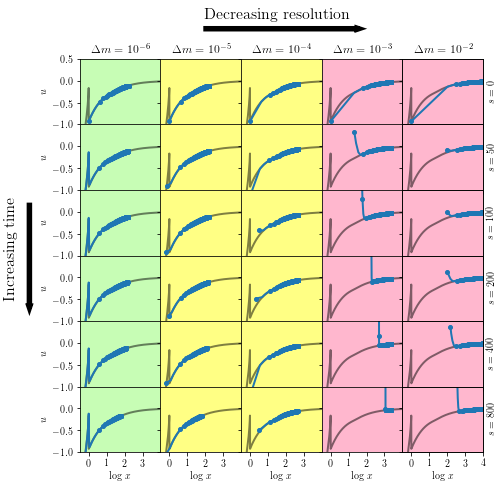

In [41]:
# Plot results at different resolutions vesus time
tplot = [0,50,100,200,400,800]
nt = len(tplot)
nrun = len(logdm)

# Prepare figure
fig = plt.figure(1, figsize=(7,7))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

# Loop over runs and times
for i in range(nt):
    row_begun = False
    for j in range(nrun):

        # Get index for this time in this run
        idx = int(round(nhist*tplot[i]/tf))
        if idx >= len(xu_hist_res[j]):
            continue

        # Make panel for this run
        plt.subplot(nt, nrun, 1+j+i*nrun)
        if j==0:
            plt.gca().set_facecolor('xkcd:pale green')
        elif j==1 or j==2:
            plt.gca().set_facecolor('xkcd:pale yellow')
        else:
            plt.gca().set_facecolor('xkcd:baby pink')

        # Plot analytic solution
        x_analyt = np.logspace(-1, 4, 1000)
        plt.plot(np.log10(x_analyt), u_inf(x_analyt, fE, fp, kT, xT),
                 lw=2, color='k', alpha=0.5)
        
        # Plot numerical solution
        step = npt[j]//200
        nsink = np.sum(xu_hist_res[j][idx,:npt[j]] == 0.5)
        plt.plot(np.log10(xu_hist_res[j][idx,nsink:npt[j]]), 
                 xu_hist_res[j][idx,npt[j]+nsink:],
                 color='C0', lw=2)
        plt.plot(np.log10(xu_hist_res[j][idx,nsink:npt[j]][::step]), 
                 xu_hist_res[j][idx,npt[j]+nsink:][::step], 'o', 
                 color='C0', ms=4)
        plt.xlim([-0.5, 4])
        plt.ylim([-1, 0.5])
        
        # Remove internal axis labels
        if i == 0:
            plt.yticks([-1, -0.5, 0, 0.5])
        else:
            plt.yticks([-1, -0.5, 0])
        if row_begun:
            plt.gca().set_yticklabels([])
        else:
            plt.ylabel(r'$u$')
            row_begun = True
        if i == nt-1 or (i == nt-2 and len(xu_hist_res[j]) < 100):
            if j == nrun-1:
                plt.xticks([0,1,2,3,4])
            else:
                plt.xticks([0,1,2,3])
            plt.xlabel(r'$\log\,x$')
        else:
            plt.xticks([0,1,2,3,4])
            plt.gca().set_xticklabels([])
        
        # Add label to first row
        if i == 0:
            plt.title(r'$\Delta m = 10^{{{:d}}}$'.
                      format(int(logdm[j])))
        
        # Add label to right panel
        if j == nrun-1:
            plt.twinx()
            plt.yticks([])
            plt.ylabel(r'$s = {:d}$'.format(int(tplot[i])))
            
# Adjust spacing
plt.subplots_adjust(hspace=0, wspace=0, left=0.15, right=0.95,
                    bottom=0.1, top=0.88)

# Add annotation
plt.gca().annotate('Increasing time', xy=(0.02, 0.1+0.78/2),
                   xytext=(0.02, 0.1+0.78/2), xycoords='figure fraction',
                   annotation_clip=False,
                   rotation=90,
                   size=16, ha='center', va='center')
plt.gca().arrow(0.05, 0.2+0.78/2, 0.0, -0.2, lw=5,
                transform=fig.transFigure, clip_on=False)
plt.gca().annotate('Decreasing resolution', xy=(0.55, 0.97),
                   xytext=(0.55, 0.97), xycoords='figure fraction',
                   annotation_clip=False,
                   size=16, ha='center', va='center')
plt.gca().arrow(0.4, 0.94, 0.3, 0.0, lw=5,
                transform=fig.transFigure, clip_on=False)

# Save
plt.savefig('res_study.pdf')

Analysis of numerical results
---------------------------

This part of the notebook carries out the momentum deposition analysis presented in section 3.3 of the paper, and produces figure 4.

In [24]:
# Calculate analytic momentum deposition
x = np.logspace(np.log10(0.5), np.log10(1600), 1000)
dp_g_true = dp_grav_inf(x, fE, fp, kT, xT)
dp_i_true = dp_IR_inf(x, fE, fp, kT, xT)
dp_u_true = dp_UV_inf(x, fp)
dp_tot_true = dp_g_true + dp_u_true + dp_i_true

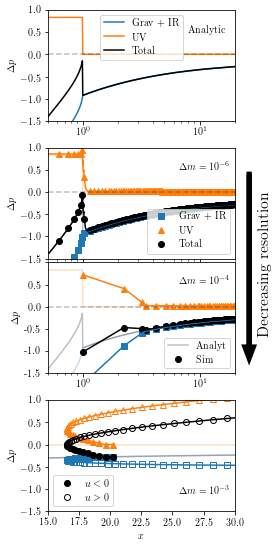

In [185]:
# Prepare plot window
import matplotlib.gridspec as gridspec
fig = plt.figure(1,figsize=(4,8))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
panelratio = 5
gs = gridspec.GridSpec(4*panelratio+2, 1)

# Plot just analytic momentum deposition
plt.subplot(gs[0:panelratio,0])

# Plot lines
plt.plot(x, (dp_g_true+dp_i_true), 'C0', label='Grav + IR')
plt.plot(x, dp_u_true, 'C1', label='UV')
plt.plot(x, dp_tot_true, 'k', label='Total')

# Add zero line
plt.plot(x, 0*x, 'k--', alpha=0.25)

# Adjust axes
plt.xscale('log')
plt.xlim([0.5,20])
plt.ylim([-1.5,1])

# Adjust labels
plt.legend(loc='upper center')
plt.text(0.75, 0.8, 'Analytic', transform=plt.gca().transAxes)
plt.ylabel(r'$\Delta p$')

# Plot monentum deposition in high resolution runs
models = [xu_sample[0], xu_sample[2]]
modeldm = [logdm[0], logdm[2]]
modelpt = 3
for i, s in enumerate(models):

    # Create panel
    plt.subplot(gs[1+(i+1)*panelratio:1+(i+2)*panelratio,0])

    # Put analytic solution in background
    plt.plot(x, dp_g_true+dp_i_true, 'C0', alpha=0.25)
    plt.plot(x, dp_u_true, 'C1', alpha=0.25)
    if i == 1:
        plt.plot(x, dp_tot_true, 'k', alpha=0.25,
                 label='Analyt')
    else:
        plt.plot(x, dp_tot_true, 'k', alpha=0.25)
    
    # Plot numerical results
    x_sim = s['x'][modelpt]
    ts = np.argmax(x_sim <= 0.5)
    if ts == len(x_sim)-1 and x_sim[-1] > 0.5:
        ts = ts+1
    x_sim = x_sim[:ts]
    dp_g_sim = np.cumsum(s['du_grav'][modelpt][:ts]) + s['u'][modelpt,0]
    dp_i_sim = np.cumsum(s['du_IR'][modelpt][:ts])
    dp_u_sim = np.cumsum(s['du_UV'][modelpt][:ts]) + \
        np.cumsum(s['du_pres'][modelpt][:ts]) + \
        np.cumsum(s['du_visc'][modelpt][:ts])
    dp_tot_sim = dp_g_sim + dp_i_sim + dp_u_sim
    if i == 0:
        plt.plot(x_sim[::10], (dp_g_sim+dp_i_sim)[::10], 'C0s', label='Grav + IR')
        plt.plot(x_sim[::10], dp_u_sim[::10], 'C1^', label='UV')
        plt.plot(x_sim[::10], dp_tot_sim[::10], 'ko', label='Total')
    else:
        plt.plot(x_sim, dp_g_sim+dp_i_sim, 'C0s')
        plt.plot(x_sim, dp_u_sim, 'C1^')
        plt.plot(x_sim, dp_tot_sim, 'ko', label='Sim')
    plt.plot(x_sim, dp_g_sim+dp_i_sim, 'C0')
    plt.plot(x_sim, dp_u_sim, 'C1')
    plt.plot(x_sim, dp_tot_sim, 'k')
    
    # Add zero line
    plt.plot(x, 0*x, 'k--', alpha=0.25)
    
     # Adjust axes
    plt.xlim([0.5,20])
    plt.xscale('log')
    plt.ylim([-1.5,1])
    
    # Adjust labels
    plt.legend(loc='lower right')
    if i == 1: plt.gca().set_yticklabels([-1.5,-1.0,-0.5,0.0,0.5])
    plt.text(0.7, 0.8, r'$\Delta m = 10^{{{:d}}}$'.
             format(int(modeldm[i])), transform=plt.gca().transAxes)
    plt.ylabel(r'$\Delta p$')
    if i == 0: plt.gca().set_xticklabels([])

    
# Plot the low resolution run
plt.subplot(gs[2+3*panelratio:2+4*panelratio,0])

# Put analytic solution in background
plt.plot(x, dp_g_true+dp_i_true, 'C0', alpha=0.25)
plt.plot(x, dp_u_true, 'C1', alpha=0.25)
plt.plot(x, dp_tot_true, 'k', alpha=0.25)

# Plot numerical results
s = xu_sample[3]
x_sim = s['x'][0]
u_sim = s['u'][0]
dp_g_sim = np.cumsum(s['du_grav'][0]) + s['u'][0,0]
dp_i_sim = np.cumsum(s['du_IR'][0])
dp_u_sim = np.cumsum(s['du_UV'][0]) + np.cumsum(s['du_visc'][0]) + np.cumsum(s['du_pres'][0])
dp_tot_sim = dp_g_sim + dp_i_sim + dp_u_sim
plt.plot(x_sim, dp_g_sim+dp_i_sim, 'C0')
plt.plot(x_sim[u_sim < 0], (dp_g_sim+dp_i_sim)[u_sim < 0], 'C0s')
plt.plot(x_sim[u_sim >=0], (dp_g_sim+dp_i_sim)[u_sim >= 0], 's', mec='C0', mfc='none')
plt.plot(x_sim, dp_u_sim, 'C1')
plt.plot(x_sim[u_sim < 0], dp_u_sim[u_sim < 0], 'C1^')
plt.plot(x_sim[u_sim >= 0], dp_u_sim[u_sim >= 0], '^', mec='C1', mfc='none')
plt.plot(x_sim, dp_tot_sim, 'k')
plt.plot(x_sim[u_sim < 0], dp_tot_sim[u_sim < 0], 'ko', label=r'$u<0$')
plt.plot(x_sim[u_sim >= 0], dp_tot_sim[u_sim >= 0], 'o', mec='k', mfc='none',
         label=r'$u>0$')

# Adjust axes
plt.xlim([15, 30])
plt.ylim([-1.5,1])

# Add labels
plt.text(0.7, 0.15, r'$\Delta m = 10^{-3}$', 
         transform=plt.gca().transAxes)
plt.xlabel(r'$x$')
plt.ylabel(r'$\Delta p$')
plt.legend(loc='lower left')

# Adjust spacing
plt.subplots_adjust(bottom=0.08, top=0.95, left=0.18, right=0.83)

# Add annotation
plt.gca().annotate('Decreasing resolution', xy=(0.94, 0.08+(0.95-0.08)/2),
                   xytext=(0.94, 0.08+(0.95-0.08)/2), xycoords='figure fraction',
                   annotation_clip=False, rotation=90,
                   size=16, ha='center', va='center')
plt.gca().arrow(0.88, 0.08+(0.95-0.08)/2+0.15, 0.0, -0.3, lw=5,
                head_width=0.03, head_length=0.02, color='k',
                transform=fig.transFigure, clip_on=False)


# Save
plt.savefig('p_vs_x.pdf')

Testing the subgrid model
------------------------

This part of the notebook carries out the subgrid model tests of section 4 the paper, and produces figure 5.

In [11]:
# Run tests at a variety of fp values and resolutions with and
# without the subgrid model
fp = [0.25, 0.5, 1, 2, 4]
dm = [1.0e-3, 1.0e-2, 1.0e-1, 1.0]
tf = [10.**2.5, 10.**3.5, 10.**4.5, 10.**5.5]
npt = 1000
xu_hist = []

# Loop over resolution
for dm_, tf_ in zip(dm, tf):
    xu_hist_dm = []
    for fp_ in fp:

        # Generate initial condition
        xu_init = infall_init(dm_, npt, x0, fE, fp_, ftau, eta,
                              kT, xT)

        # Run simulation without subgrid model
        xu = np.copy(xu_init)
        xu_hist_nosg, tf_nosg \
            = run_sim(xu, tf_, dm_, fE, ftau, eta, kT, xT,
                      nu=2.0, cs2=1.0e-3, xsink=0.5,
                      cfl=0.5, verbose=True)
        print("Completed logdm = {:f}, fp = {:f}, no subgrid; tf = {:f}".
              format(np.log10(dm_), fp_, tf_nosg))
            
        # Run the same simulation with the subgrid model
        xu = np.copy(xu_init)
        xu_hist_sg, tf_sg \
            = run_sim(xu, tf_, dm_, fE, ftau, eta, kT, xT,
                      nu=2.0, cs2=1.0e-3, xsink=0.5,
                      cfl=0.5, 
                      use_subgrid=True, verbose=True)
        print("Completed logdm = {:f}, fp = {:f}, with subgrid; tf = {:f}".
              format(np.log10(dm_), fp_, tf_sg))

        # Store
        xu_hist_dm.append({
            'sg' : xu_hist_sg,
            'nosg' : xu_hist_nosg
        })
        
    # Store for this dm
    xu_hist.append(xu_hist_dm)

Completed logdm = -3.000000, fp = 0.250000, no subgrid; tf = 316.227766
Completed logdm = -3.000000, fp = 0.250000, with subgrid; tf = 316.227766
Completed logdm = -3.000000, fp = 0.500000, no subgrid; tf = 316.227766
Completed logdm = -3.000000, fp = 0.500000, with subgrid; tf = 316.227766
Completed logdm = -3.000000, fp = 1.000000, no subgrid; tf = 316.227766
Completed logdm = -3.000000, fp = 1.000000, with subgrid; tf = 316.227766
Completed logdm = -3.000000, fp = 2.000000, no subgrid; tf = 316.227766
Completed logdm = -3.000000, fp = 2.000000, with subgrid; tf = 316.227766
Completed logdm = -3.000000, fp = 4.000000, no subgrid; tf = 316.227766
Completed logdm = -3.000000, fp = 4.000000, with subgrid; tf = 316.227766
Completed logdm = -2.000000, fp = 0.250000, no subgrid; tf = 3162.277660
Completed logdm = -2.000000, fp = 0.250000, with subgrid; tf = 3162.277660
Completed logdm = -2.000000, fp = 0.500000, no subgrid; tf = 3162.277660
Completed logdm = -2.000000, fp = 0.500000, with 

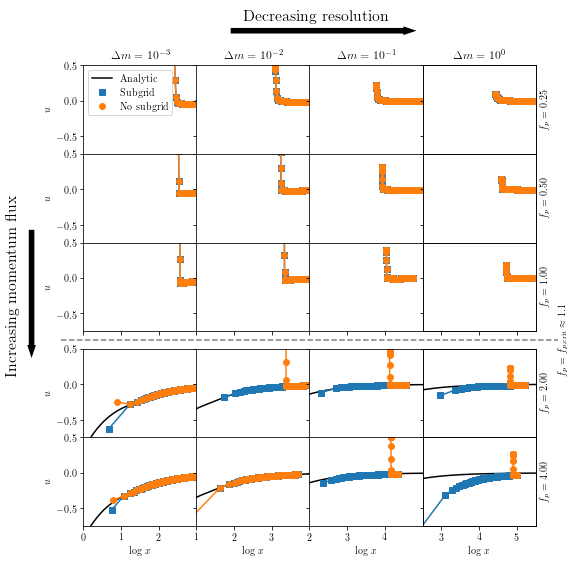

In [35]:
# Plot results
import matplotlib.gridspec as gridspec
fig = plt.figure(1, figsize=(8,8))
plt.rc('text', usetex=True)
plt.rc('font', family='serif')
panelratio = 5
gs = gridspec.GridSpec(len(fp)*panelratio+1, len(dm))

# Loop over runs
for j in range(len(dm)):
    for i in range(len(fp)):
    
        # Add frame
        if fp[i] < fpcrit_inf(fE, kT, xT):
            plt.subplot(gs[i*panelratio:(i+1)*panelratio,j])
        else:
            plt.subplot(gs[1+i*panelratio:1+(i+1)*panelratio,j])
    
        # Plot analytic result for fp > fp_crit
        if fp[i] > fpcrit_inf(fE, kT, xT):
            x_analyt = np.logspace(0, 6, 500)
            plt.plot(np.log10(x_analyt), u_inf(x_analyt, fE, fp[0], kT, xT),
                     'k', label='Analytic')
        else:
            plt.plot([-100,-100], [-100,-100], 'k', label='Analytic')

        # Plot numerical result
        sg = xu_hist[j][i]['sg'][-1]
        nxsink_sg = np.sum(sg[:npt] == 0.5)
        nosg = xu_hist[j][i]['nosg'][-1]
        nxsink_nosg = np.sum(nosg[:npt] == 0.5)
        plt.plot(np.log10(sg[nxsink_sg:npt]), sg[npt+nxsink_sg:], 'C0s',
                 label='Subgrid')
        plt.plot(np.log10(sg[nxsink_sg:npt]), sg[npt+nxsink_sg:], 'C0')
        plt.plot(np.log10(nosg[nxsink_nosg:npt]), nosg[npt+nxsink_nosg:], 'C1o',
                label='No subgrid')
        plt.plot(np.log10(nosg[nxsink_nosg:npt]), nosg[npt+nxsink_nosg:], 'C1')
    
        # Adjust plot axes
        if j==0:
            plt.xlim([0,3])
            plt.gca().set_xticks([0,1,2])
        elif j==1:
            plt.xlim([1,4])
            plt.gca().set_xticks([1,2,3])
        elif j==2:
            plt.xlim([2,5])
            plt.gca().set_xticks([2,3,4])
        elif j==3:
            plt.xlim([2.5,5.5])
            plt.gca().set_xticks([3,4,5])
        plt.ylim([-0.75,0.5])
        
        # Adjust labels
        if i==0 and j==0:
            plt.legend()
        if i != len(fp)-1:
            plt.gca().set_xticklabels([])
        else:
            plt.xlabel(r'$\log\,x$')
        if j != 0:
            plt.gca().set_yticklabels([])
        else:
            plt.ylabel(r'$u$')
        if i == 0:
            plt.title(r'$\Delta m = 10^{{{:d}}}$'
                      .format(int(np.round(np.log10(dm[j])))))
        if j == len(dm)-1:
            plt.twinx()
            plt.gca().set_yticks([])
            plt.ylabel(r'$f_p = {:4.2f}$'.format(fp[i]))
            
# Adjust spacing
plt.subplots_adjust(hspace=0, wspace=0, left=0.14, right=0.925,
                    bottom=0.08, top=0.88)

# Add annotation
plt.gca().annotate('Increasing momentum flux', xy=(0.02, 0.1+0.78/2),
                   xytext=(0.02, 0.1+0.78/2), xycoords='figure fraction',
                   annotation_clip=False,
                   rotation=90,
                   size=16, ha='center', va='center')
plt.gca().arrow(0.05, 0.2+0.78/2, 0.0, -0.2, lw=5,
                transform=fig.transFigure, clip_on=False)
plt.gca().annotate('Decreasing resolution', xy=(0.55, 0.97),
                   xytext=(0.55, 0.97), xycoords='figure fraction',
                   annotation_clip=False,
                   size=16, ha='center', va='center')
plt.gca().arrow(0.4, 0.94, 0.3, 0.0, lw=5,
                transform=fig.transFigure, clip_on=False)

# Add dividing line
plt.subplot(gs[3*panelratio:3*panelratio+1,:])
plt.plot([-0.05,1.05], [0.5,0.5], 'k--', alpha=0.5, clip_on=False)
plt.text(1.06, 0.5, r'$f_p = f_{p,\mathrm{crit}} \approx 1.1$',
         clip_on=False, rotation=90, ha='center', va='center')
plt.xlim([0,1])
plt.ylim([0,1])
plt.gca().spines['left'].set_visible(False)
plt.gca().spines['right'].set_visible(False)
plt.gca().spines['bottom'].set_visible(False)
plt.gca().spines['top'].set_visible(False)
plt.gca().set_xticks([])
plt.gca().set_yticks([])
plt.gca().patch.set_alpha(0.0)

# Save
plt.savefig('subgrid.pdf')